In [16]:
# Setup
# Install dependencies required by this notebook
%pip install -q pandas numpy matplotlib seaborn plotly python-bidi

import pandas as pd
import numpy as np
import re
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

import plotly.graph_objects as go
from plotly.subplots import make_subplots

from bidi.algorithm import get_display
import re as _re2

def he(text):
    s = str(text) if text is not None else ''
    if _re2.search(r'[\u0590-\u05FF]', s):
        return get_display(s)
    return s

plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False
sns.set(style='whitegrid', context='talk')



[notice] A new release of pip is available: 23.1.2 -> 25.2
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [17]:
# Load & clean
path = 'balance.csv'

def to_num(s):
    s = (str(s) if s is not None else '').strip()
    if s == '':
        return 0.0
    try:
        return float(s)
    except Exception:
        import re as _re
        s2 = _re.sub(r'[^\d\-]', '', s)
        try:
            return float(s2) if s2 else 0.0
        except Exception:
            return 0.0

raw = pd.read_csv(path, header=0, encoding='utf-8-sig')
# Drop the first two empty columns if present
if raw.columns[:2].tolist() == ['Unnamed: 0', 'Unnamed: 1'] or raw.shape[1] >= 2 and raw.columns[0] == '' and raw.columns[1] == '':
    pass

# The file actually has two leading empty columns; re-read with manual handling
raw_list = list(pd.read_csv(path, header=None, encoding='utf-8-sig').values)
header = raw_list[0][2:]
rows = []
for r in raw_list[1:]:
    r = list(r)
    r = r[2:]  # drop 2 empties
    if len(r) < 8:
        r += [''] * (8 - len(r))
    rows.append(r)

# New column added: 'הבאתי תשתית הקרנה?' before 'חשבונית'
cols = ['תאריך','הפקה','סאונד','לקוח','תשלום','הערות','הבאתי תשתית הקרנה?','חשבונית']
df = pd.DataFrame(rows, columns=cols)

# Parse date
def parse_date(s):
    s = str(s).strip()
    if not s:
        return pd.NaT
    try:
        d, m, y = s.split('.')
        y = int(y)
        if y < 100:
            y += 2000
        return pd.Timestamp(int(y), int(m), int(d))
    except Exception:
        return pd.NaT

df['date'] = df['תאריך'].apply(parse_date)
df = df.dropna(subset=['date']).copy()

# Numeric fields
df['payment'] = df['תשלום'].apply(to_num)
df['invoice'] = df['חשבונית'].apply(to_num)

# Projection infrastructure boolean
proj_raw = df['הבאתי תשתית הקרנה?'].fillna('').astype(str).str.strip()
df['projection_infra'] = proj_raw.isin(['כן','כן.', 'Yes','yes','TRUE','True','1'])

# Income formula
# income = payment - 0.05 * invoice (invoice missing treated as 0)
df['income'] = df['payment'] - 0.05 * df['invoice'].fillna(0)

# Features
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['weekday'] = df['date'].dt.weekday

# Flags
df['has_roy'] = df['הערות'].fillna('').str.contains(r'\d+\s*לרועי', regex=True)
df['with_lior'] = df['הערות'].fillna('').str.contains('ליאור קודמן')
df['with_yesplease'] = df['הערות'].fillna('').str.contains('ליד יס פליז')
df['volunteer'] = (df['payment'] <= 0) | df['הערות'].fillna('').str.contains('התנדבות')
# band heuristic
df['band_like'] = df['הערות'].fillna('').str.contains('מופע|להקה') | df['לקוח'].fillna('').str.contains('מופע')

# Clean client variants for מגוונים
is_mego = df['לקוח'].fillna('').str.startswith('מגוונים') | (df['לקוח'] == 'מגוונים')
df['client_norm'] = df['לקוח']
df.loc[is_mego, 'client_norm'] = 'מגוונים'

print('Rows:', len(df), 'Date range:', df['date'].min().date(), '→', df['date'].max().date())
df.head()


Rows: 128 Date range: 2020-02-23 → 2025-11-02


,תאריך,הפקה,סאונד,לקוח,תשלום,הערות,הבאתי תשתית הקרנה?,חשבונית,date,payment,...,income,year,month,weekday,has_roy,with_lior,with_yesplease,volunteer,band_like,client_norm
0,23.2.20,רויטל,אלון,רחובות,300,ערב שירה,כן,NaN,2020-02-23,300.0,...,300.0,2020,2,6,False,False,False,False,False,רחובות
1,27.2.20,אורן אדרי,אורן אדרי,גרין פאב,450,NaN,NaN,NaN,2020-02-27,450.0,...,450.0,2020,2,3,False,False,False,False,False,גרין פאב
2,12.3.20,אורן אדרי,אורן אדרי,באר שבע,400,NaN,NaN,NaN,2020-03-12,400.0,...,400.0,2020,3,3,False,False,False,False,False,באר שבע
3,3.7.20,אלון,אלון,זוקו קרית אונו,300,NaN,NaN,NaN,2020-07-03,300.0,...,300.0,2020,7,4,False,False,False,False,False,זוקו קרית אונו
4,4.7.20,אלון,אלון,אורי וליאת,400,NaN,כן,NaN,2020-07-04,400.0,...,400.0,2020,7,5,False,False,False,False,False,אורי וליאת


In [18]:
# KPIs
from collections import Counter, defaultdict

kpis = {}
kpis['total_gigs'] = len(df)
kpis['date_range'] = (df['date'].min().date(), df['date'].max().date())
kpis['total_income'] = float(df['income'].sum())
kpis['mean_income'] = float(df['income'].mean())
kpis['median_income'] = float(df['income'].median())
q25 = df['income'].quantile(0.25)
q75 = df['income'].quantile(0.75)
kpis['p25'] = float(q25)
kpis['p75'] = float(q75)

# Yearly aggregates
yr = df.groupby('year').agg(gigs=('income','count'), income_total=('income','sum'))
yr['avg_income'] = yr['income_total']/yr['gigs']
yr



,gigs,income_total,avg_income
year,,,
2020,8,5250.00,656.250000
2021,21,25296.25,1204.583333
2022,26,30720.00,1181.538462
2023,22,20098.50,913.568182
2024,29,30687.50,1058.189655
2025,22,34485.85,1567.538636


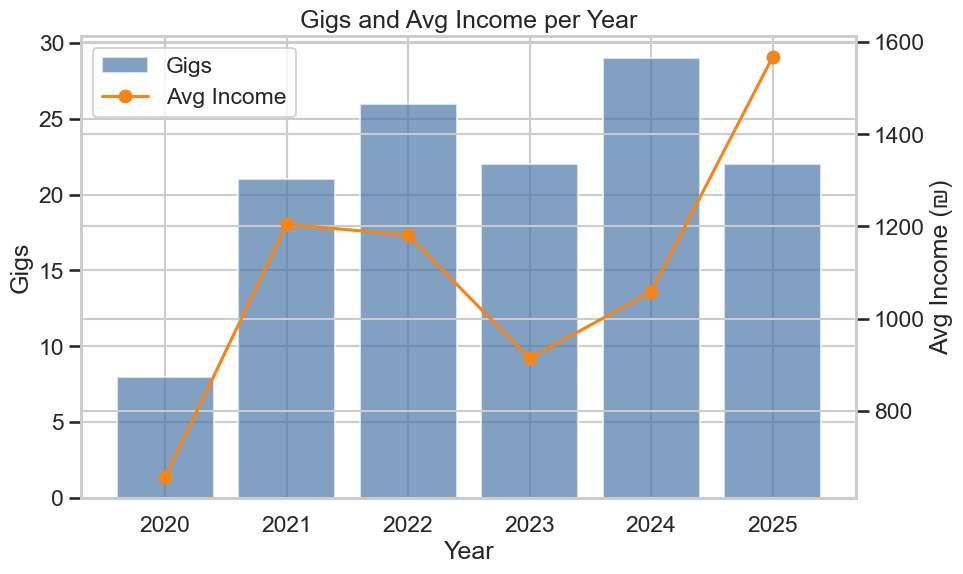

In [19]:
# Yearly 3D: Volume vs Avg Income
# 3D bar: x=year, y=gigs, z=avg income (using plotly)

yr_plot = yr.reset_index().rename(columns={'year':'Year','gigs':'Gigs','avg_income':'AvgIncome','income_total':'IncomeTotal'})

fig = go.Figure(data=[
    go.Scatter3d(
        x=yr_plot['Year'],
        y=yr_plot['Gigs'],
        z=yr_plot['AvgIncome'],
        mode='markers+lines',
        marker=dict(size=8, color=yr_plot['AvgIncome'], colorscale='Viridis', showscale=True),
        line=dict(color='gray')
    )
])
fig.update_layout(
    title='Yearly Volume vs Avg Income (3D)',
    scene=dict(
        xaxis_title='Year',
        yaxis_title='Gigs',
        zaxis_title='Avg Income (₪)'
    ),
    height=600
)
fig.show()

# Companion 2D: dual-axis - gigs (bar) & avg income (line)
fig2, ax1 = plt.subplots(figsize=(10,6))
ax2 = ax1.twinx()
ax1.bar(yr_plot['Year'], yr_plot['Gigs'], color='#4C78A8', alpha=0.7, label='Gigs')
ax2.plot(yr_plot['Year'], yr_plot['AvgIncome'], color='#F58518', marker='o', label='Avg Income')
ax1.set_xlabel('Year')
ax1.set_ylabel('Gigs')
ax2.set_ylabel('Avg Income (₪)')
ax1.set_title('Gigs and Avg Income per Year')

# Combine legends
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc='upper left')
plt.show()


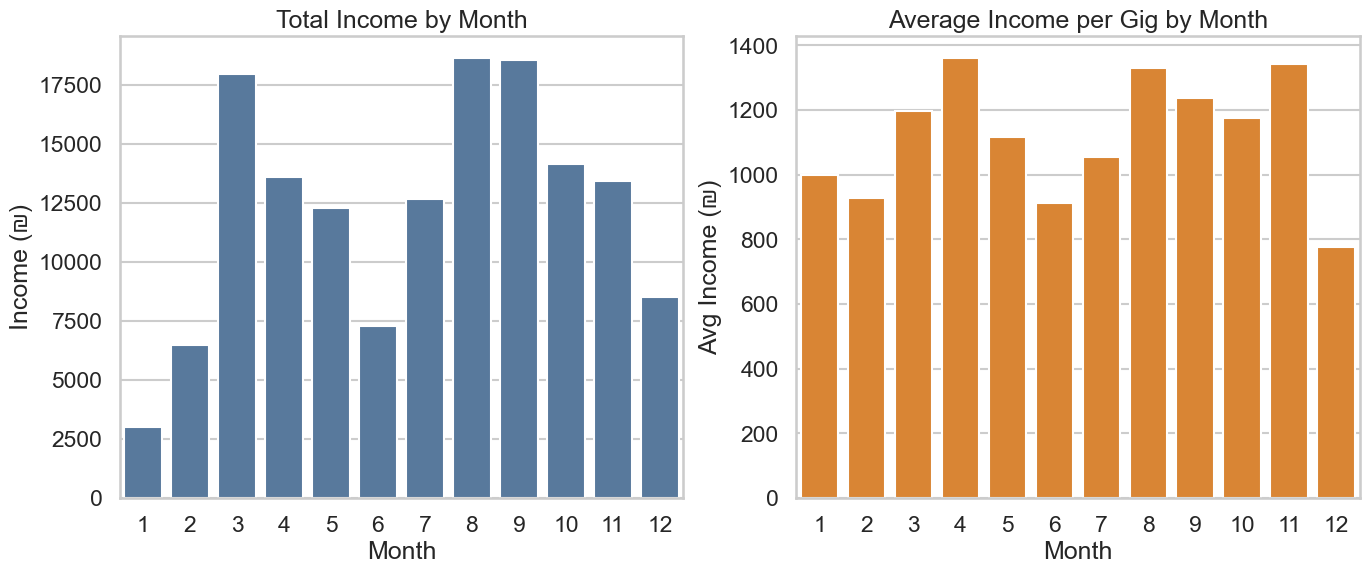

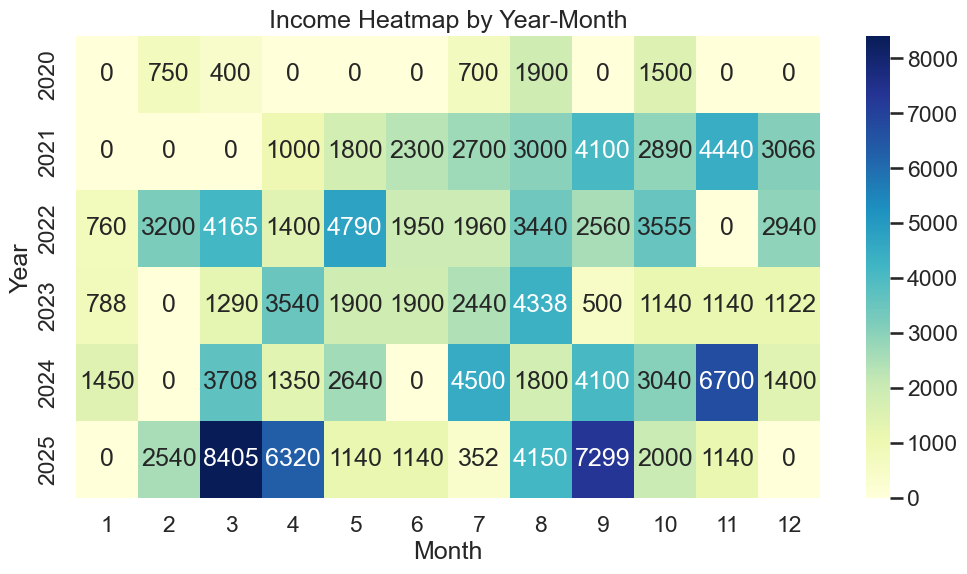

In [20]:
# Seasonality: Month totals, avg, and heatmap by year-month
mon = df.groupby('month').agg(gigs=('income','count'), income_total=('income','sum'))
mon['avg_income'] = mon['income_total']/mon['gigs']

fig, axes = plt.subplots(1, 2, figsize=(16,6))
# Total income by month
sns.barplot(ax=axes[0], x=mon.index, y=mon['income_total'], color='#4C78A8')
axes[0].set_title('Total Income by Month')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Income (₪)')
# Avg income by month
sns.barplot(ax=axes[1], x=mon.index, y=mon['avg_income'], color='#F58518')
axes[1].set_title('Average Income per Gig by Month')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Avg Income (₪)')
plt.show()

# Heatmap: income by year-month
pivot = df.pivot_table(index='year', columns='month', values='income', aggfunc='sum', fill_value=0)
plt.figure(figsize=(12,6))
sns.heatmap(pivot, annot=True, fmt='.0f', cmap='YlGnBu')
plt.title('Income Heatmap by Year-Month')
plt.xlabel('Month')
plt.ylabel('Year')
plt.show()


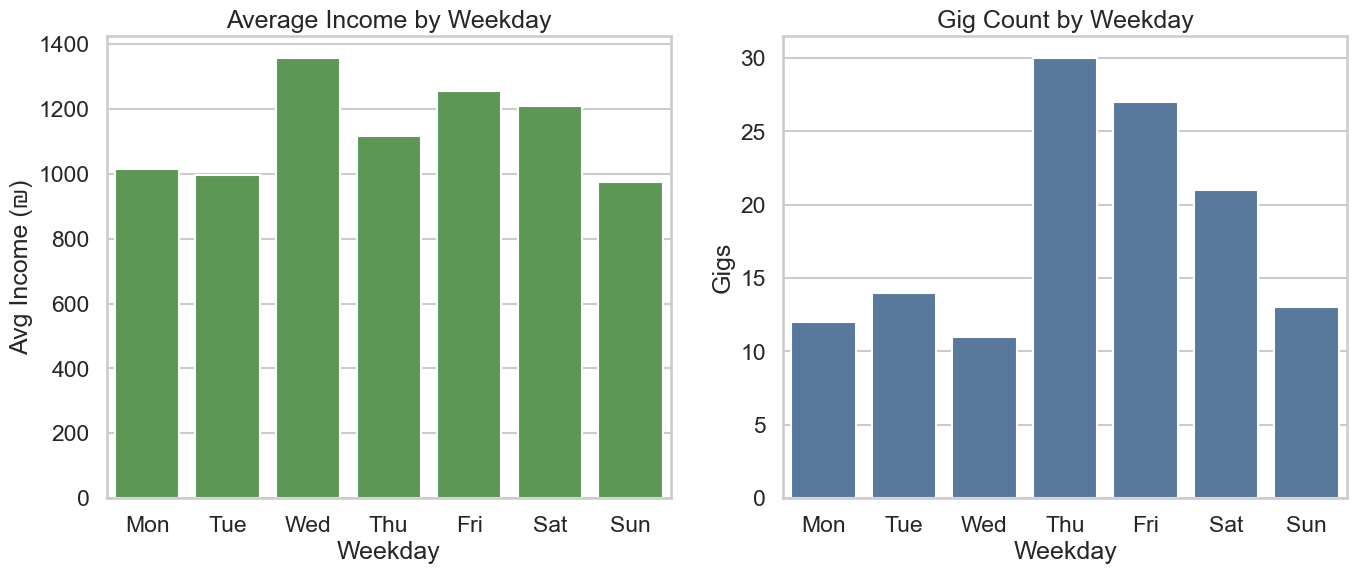

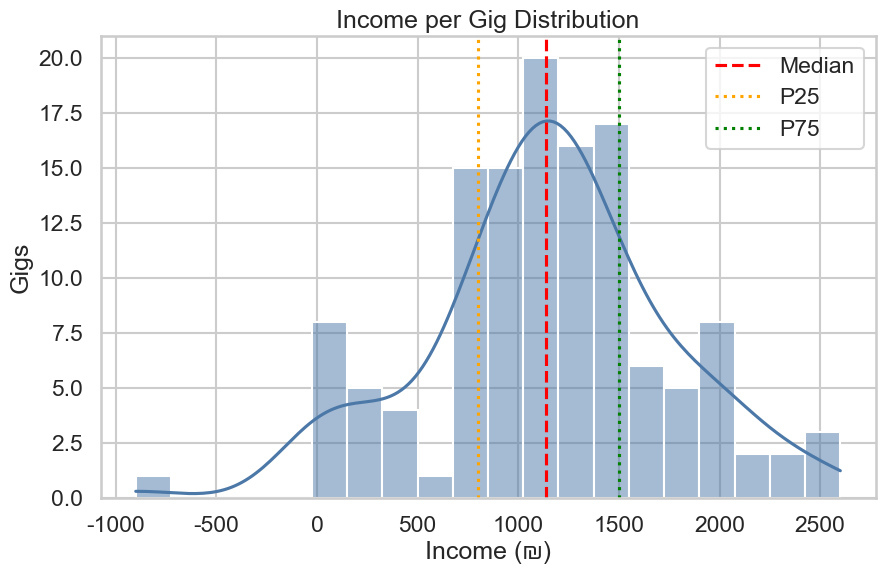

In [21]:
# Weekday and Price Distribution
# Weekday
wd_map = {0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'}
df['weekday_name'] = df['weekday'].map(wd_map)
wd = df.groupby('weekday_name').agg(gigs=('income','count'), avg_income=('income','mean')).reindex(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])

fig, ax = plt.subplots(1,2, figsize=(16,6))
sns.barplot(ax=ax[0], x=wd.index, y=wd['avg_income'], color='#54A24B')
ax[0].set_title('Average Income by Weekday')
ax[0].set_xlabel('Weekday')
ax[0].set_ylabel('Avg Income (₪)')

sns.countplot(ax=ax[1], x='weekday_name', data=df, order=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'], color='#4C78A8')
ax[1].set_title('Gig Count by Weekday')
ax[1].set_xlabel('Weekday')
ax[1].set_ylabel('Gigs')
plt.show()

# Price distribution and percentiles
fig, ax = plt.subplots(figsize=(10,6))
sns.histplot(df['income'], bins=20, kde=True, color='#4C78A8')
ax.axvline(df['income'].median(), color='red', linestyle='--', label='Median')
ax.axvline(df['income'].quantile(0.25), color='orange', linestyle=':', label='P25')
ax.axvline(df['income'].quantile(0.75), color='green', linestyle=':', label='P75')
ax.set_title('Income per Gig Distribution')
ax.set_xlabel('Income (₪)')
ax.set_ylabel('Gigs')
ax.legend()
plt.show()


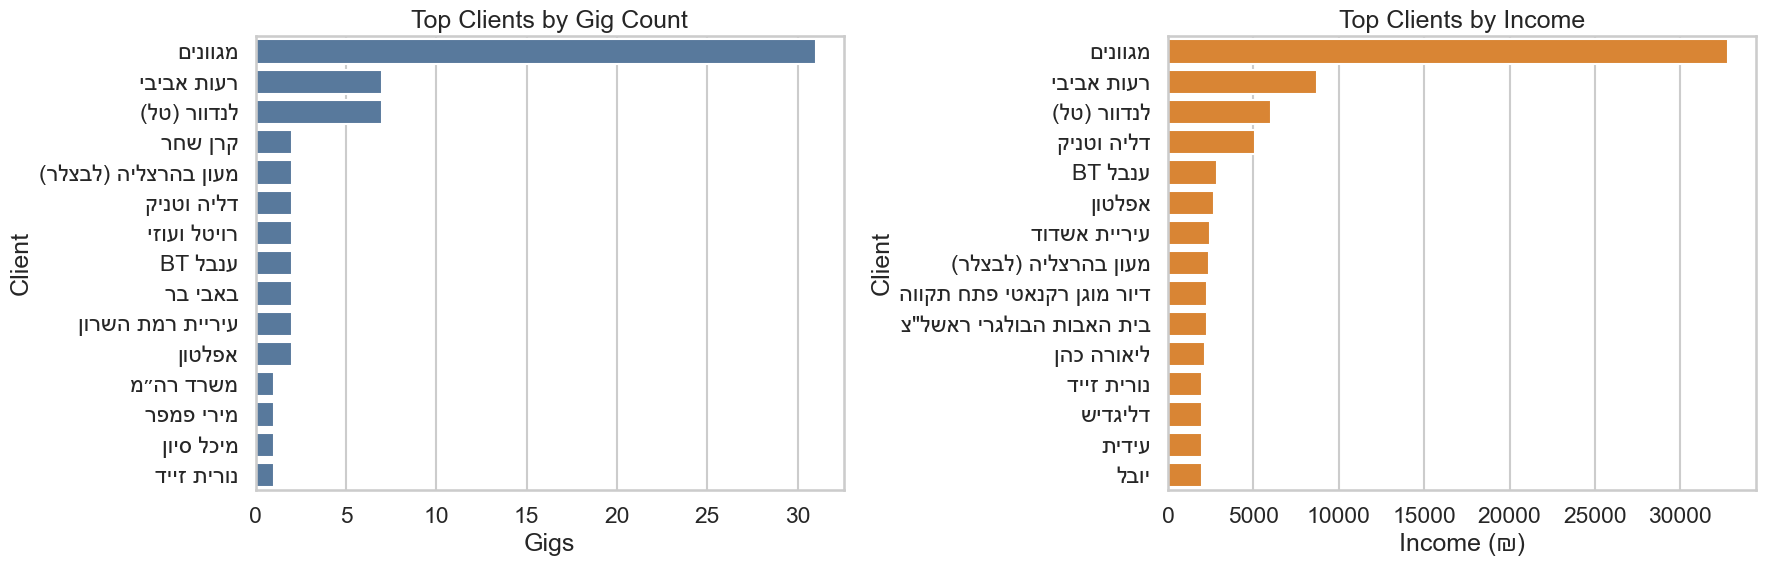

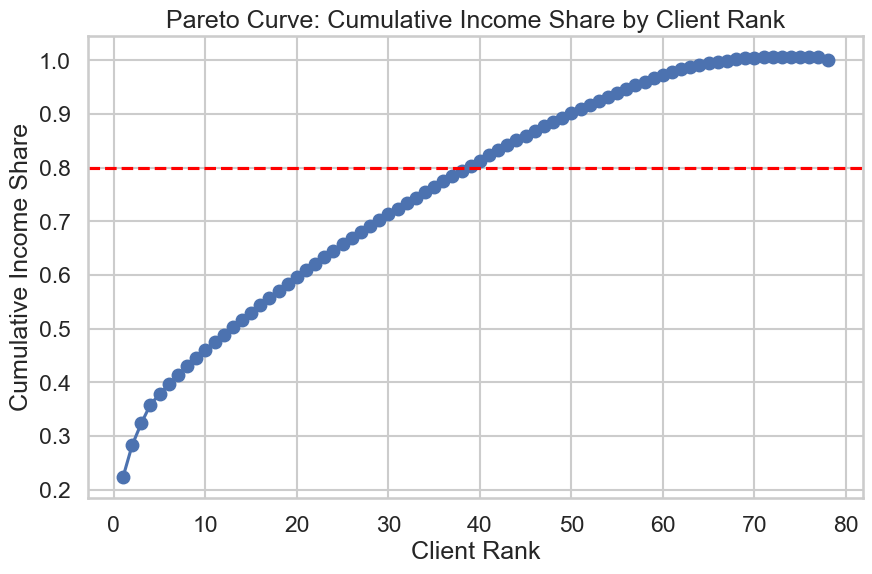

In [22]:
# Clients: top by count/income and Pareto cumulative
cl_count = df.groupby('client_norm').size().sort_values(ascending=False).head(15)
cl_income = df.groupby('client_norm')['income'].sum().sort_values(ascending=False).head(15)

fig, ax = plt.subplots(1,2, figsize=(18,6))
sns.barplot(ax=ax[0], x=cl_count.values, y=[he(v) for v in cl_count.index], color='#4C78A8')
ax[0].set_title('Top Clients by Gig Count')
ax[0].set_xlabel('Gigs')
ax[0].set_ylabel('Client')

sns.barplot(ax=ax[1], x=cl_income.values, y=[he(v) for v in cl_income.index], color='#F58518')
ax[1].set_title('Top Clients by Income')
ax[1].set_xlabel('Income (₪)')
ax[1].set_ylabel('Client')
plt.tight_layout()
plt.show()

# Pareto: cumulative share of income by client
tmp = df.groupby('client_norm')['income'].sum().sort_values(ascending=False)
cum = tmp.cumsum()/tmp.sum()
plt.figure(figsize=(10,6))
plt.plot(range(1,len(cum)+1), cum.values, marker='o')
plt.title('Pareto Curve: Cumulative Income Share by Client Rank')
plt.xlabel('Client Rank')
plt.ylabel('Cumulative Income Share')
plt.axhline(0.8, color='red', linestyle='--')
plt.grid(True)
plt.show()


/var/folders/tr/_8q7bfh92lqdqnhl95px0cvm0000gp/T/ipykernel_33131/1218252952.py:25: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




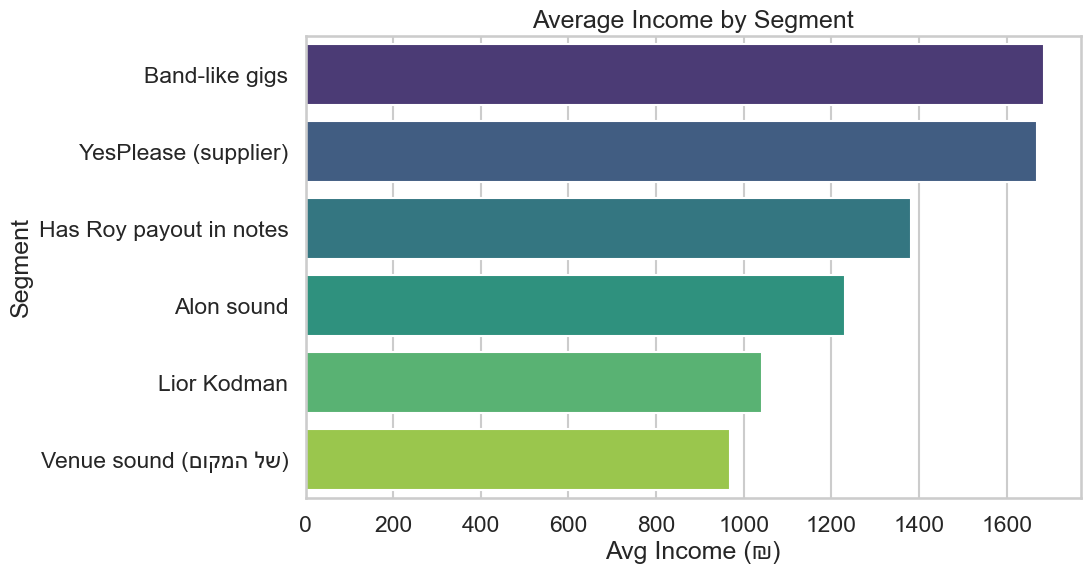

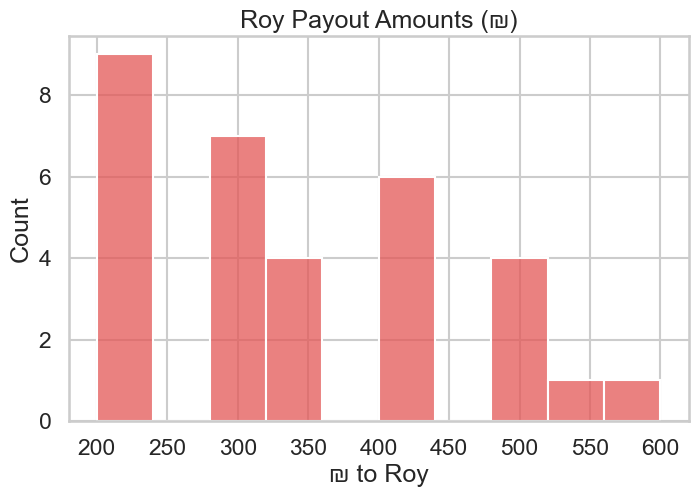

In [23]:
# Segments & collaborators
import numpy as np

segments = {
    'YesPlease (supplier)': df['with_yesplease'],
    'Lior Kodman': df['with_lior'],
    he('Has Roy payout in notes'): df['has_roy'],
    he('Band-like gigs'): df['band_like'],
    he('Venue sound (של המקום)'): df['סאונד'].eq('של המקום'),
    he('Alon sound'): df['סאונד'].eq('אלון'),
}

summary = []
for name, mask in segments.items():
    sub = df[mask]
    n = len(sub)
    avg = sub['income'].mean() if n else np.nan
    summary.append((name, n, avg))

seg_df = pd.DataFrame(summary, columns=['Segment','Gigs','AvgIncome']).sort_values('AvgIncome', ascending=False)
seg_df

# Visual compare
plt.figure(figsize=(10,6))
sns.barplot(data=seg_df.dropna(), x='AvgIncome', y='Segment', palette='viridis')
plt.title('Average Income by Segment')
plt.xlabel('Avg Income (₪)')
plt.ylabel('Segment')
plt.show()

# Roy payout: distribution of payout amounts extracted from notes
roy_amounts = []
for note in df['הערות'].fillna(''):
    m = re.search(r'(\d+)\s*לרועי', note)
    if m:
        roy_amounts.append(float(m.group(1)))

if roy_amounts:
    plt.figure(figsize=(8,5))
    sns.histplot(roy_amounts, bins=10, color='#E45756')
    plt.title('Roy Payout Amounts (₪)')
    plt.xlabel('₪ to Roy')
    plt.ylabel('Count')
    plt.show()



/var/folders/tr/_8q7bfh92lqdqnhl95px0cvm0000gp/T/ipykernel_33131/421755332.py:22: FutureWarning:

'Y' is deprecated and will be removed in a future version, please use 'YE' instead.



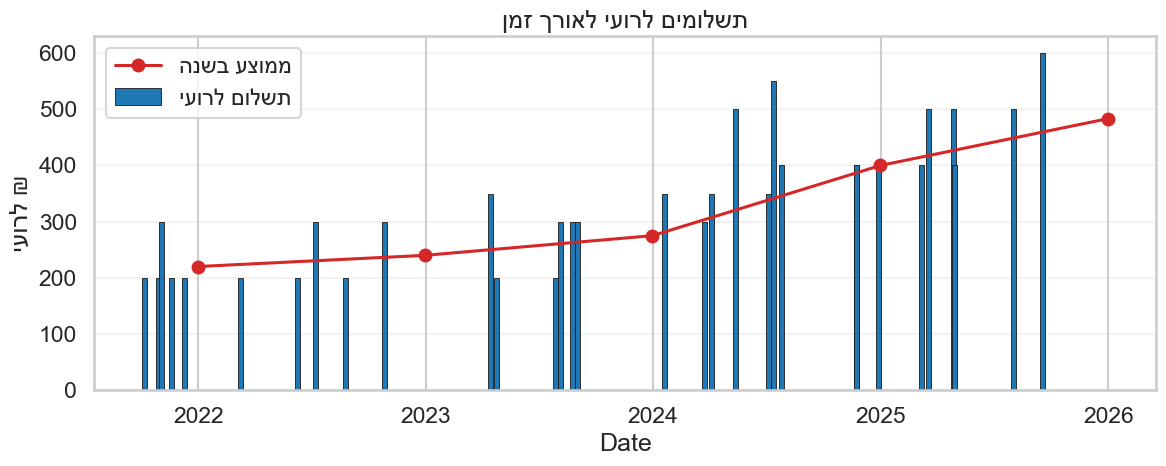

In [39]:
# Roy payouts over time (bar chart)
# Extract payout amounts and plot as time-series bars + rolling trend line
from matplotlib.dates import YearLocator, DateFormatter

roy_rows = []
for _, row in df.iterrows():
    note = str(row['הערות']) if pd.notna(row['הערות']) else ''
    m = re.search(r'(\d+)\s*לרועי', note)
    if m:
        amt = float(m.group(1))
        roy_rows.append({'date': row['date'], 'amount': amt})

roy_df = pd.DataFrame(roy_rows).sort_values('date')

plt.figure(figsize=(12,5))
ax = plt.gca()
ax.bar(roy_df['date'], roy_df['amount'], width=8, color='#1f77b4', alpha=1.0, edgecolor='#1a1a1a', linewidth=0.6, label=he('תשלום לרועי'))

# Yearly total payout trend line (similar style to מגוונים)
if not roy_df.empty:
    s = roy_df.set_index('date')['amount'].sort_index()
    trend_year = s.resample('Y').mean()
    ax.plot(trend_year.index, trend_year.values, color='#d62728', linewidth=2.2, marker='o', label=he('ממוצע בשנה'))

ax.xaxis.set_major_locator(YearLocator(base=1))
ax.xaxis.set_major_formatter(DateFormatter('%Y'))
plt.title(he('תשלומים לרועי לאורך זמן'))
plt.xlabel('Date')
plt.ylabel(he('₪ לרועי'))
ax.grid(True, axis='y', alpha=0.25)
ax.legend(loc='upper left')
plt.tight_layout()
plt.show()


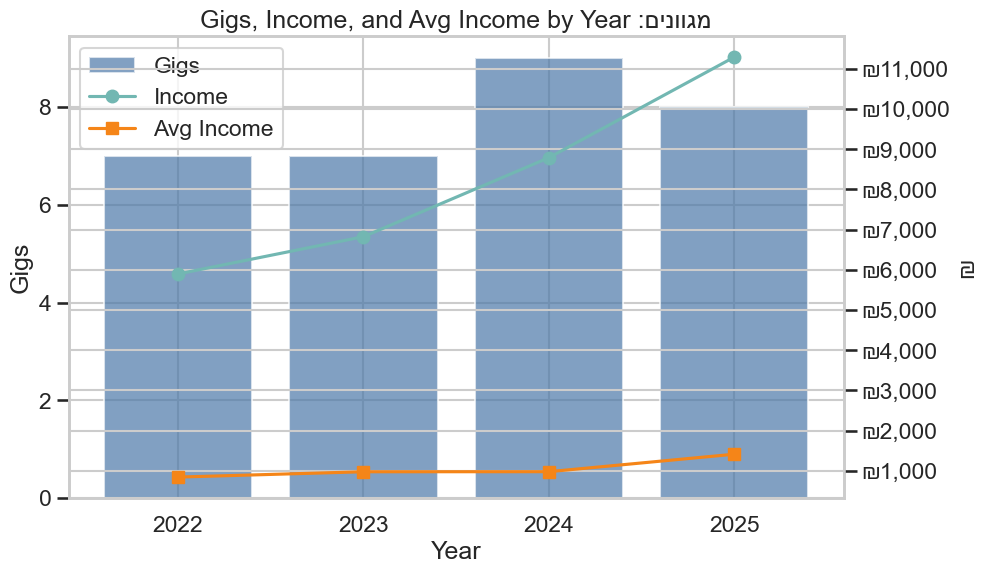

In [31]:
# Key account: מגוונים trend
mego = df[df['client_norm']=='מגוונים']
trend = mego.groupby('year').agg(gigs=('income','count'), income=('income','sum'))
trend['avg_income'] = trend['income']/trend['gigs']
trend

fig, ax1 = plt.subplots(figsize=(10,6))
ax2 = ax1.twinx()
trend_plot = trend.reset_index()
ax1.bar(trend_plot['year'], trend_plot['gigs'], color='#4C78A8', alpha=0.7, label='Gigs')
ax2.plot(trend_plot['year'], trend_plot['income'], color='#72B7B2', marker='o', label='Income')
ax2.plot(trend_plot['year'], trend_plot['avg_income'], color='#F58518', marker='s', label='Avg Income')
ax1.set_title(he('מגוונים: Gigs, Income, and Avg Income by Year'))
ax1.set_xlabel('Year')
ax1.set_ylabel('Gigs')
ax2.set_ylabel('₪')

h1,l1 = ax1.get_legend_handles_labels()
h2,l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+l2, l1+l2, loc='upper left')
plt.show()


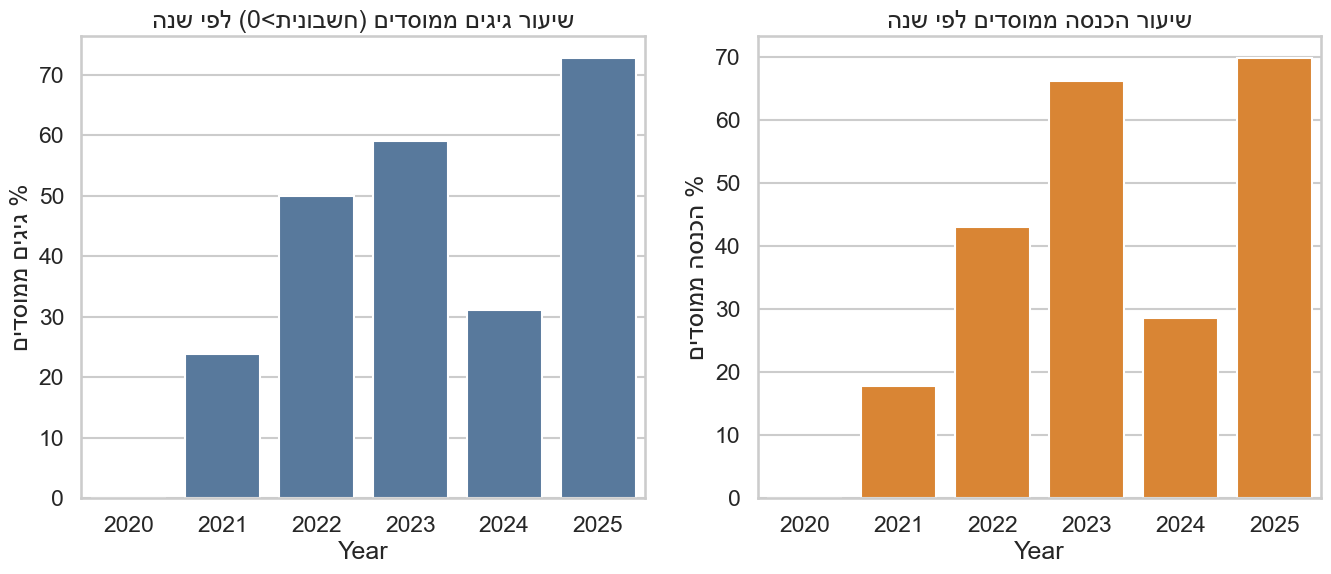

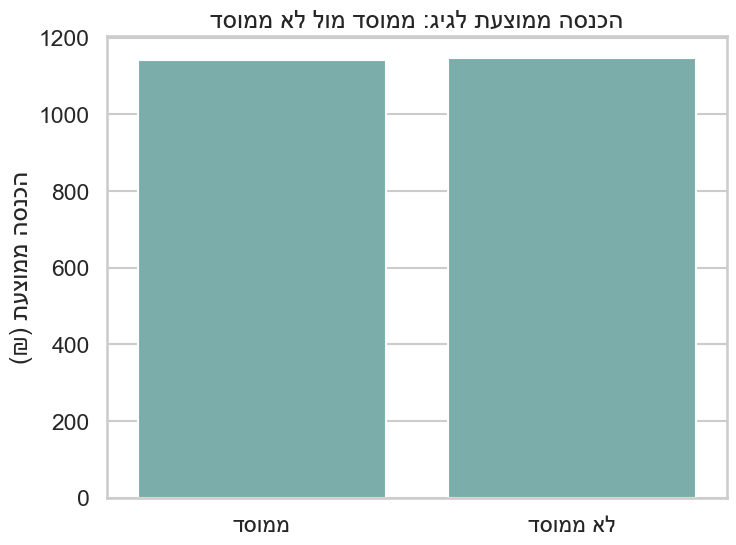

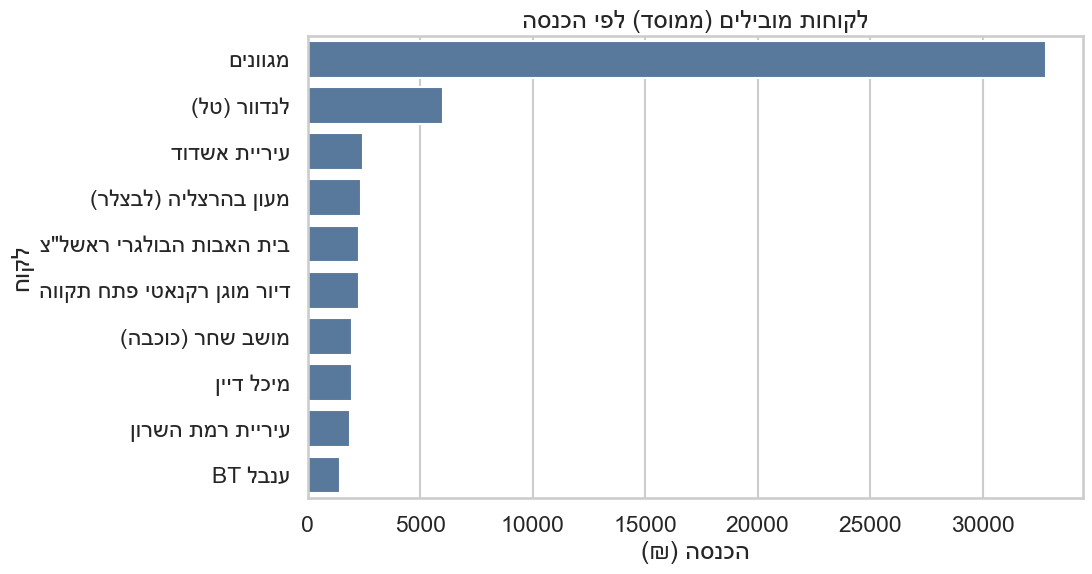

/var/folders/tr/_8q7bfh92lqdqnhl95px0cvm0000gp/T/ipykernel_33131/152770165.py:49: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



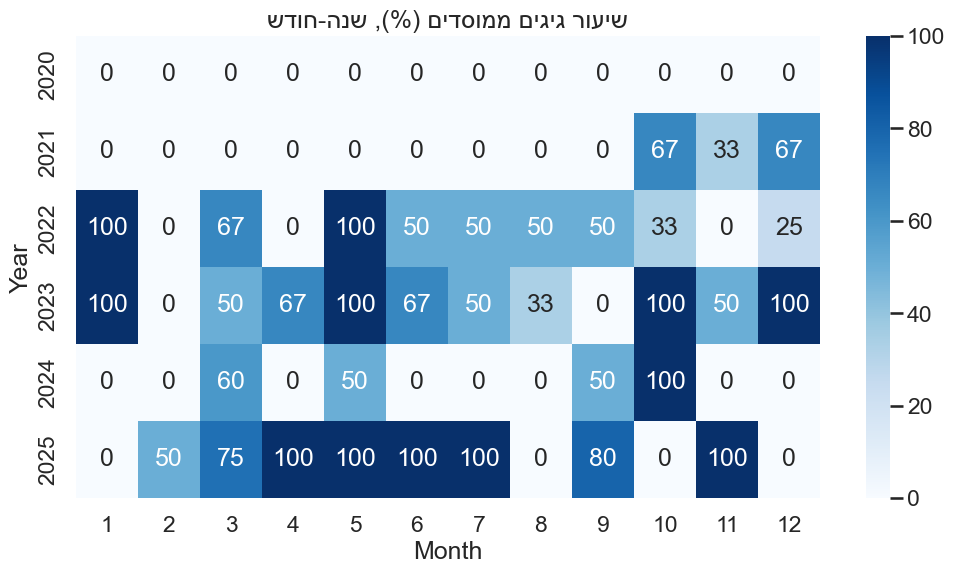

<Figure size 1000x600 with 0 Axes>

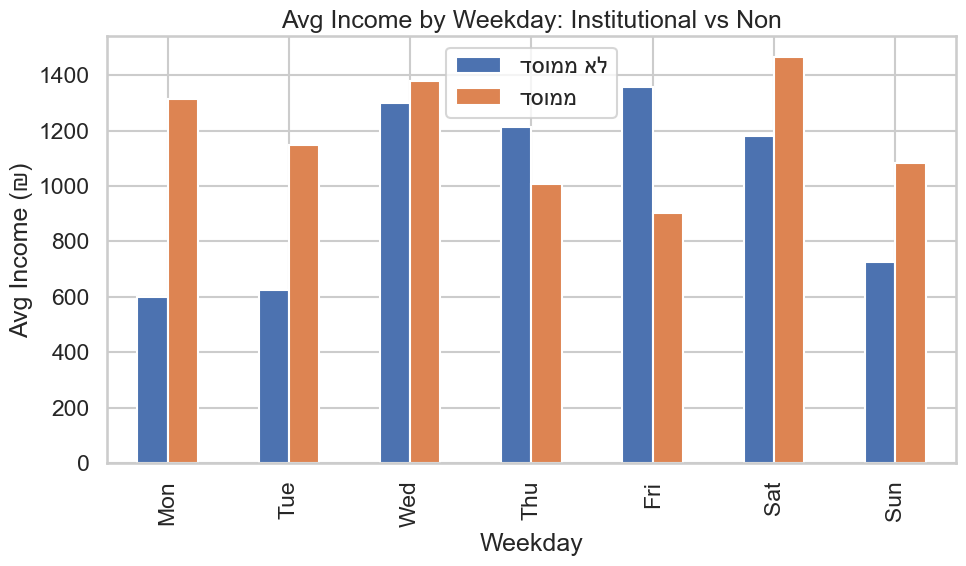

In [25]:
# Institutionalized vs Non-Institutionalized (Invoices)
# Institutionalized = invoice > 0

df['institutional'] = df['invoice'] > 0

# Yearly breakdown: % institutional gigs and income share
year_inst = df.groupby(['year','institutional']).agg(gigs=('income','count'), income=('income','sum')).reset_index()
# Compute percentages per year
summary = year_inst.pivot(index='year', columns='institutional', values=['gigs','income']).fillna(0)
summary.columns = [f"{m}_{'institutional' if b else 'non'}" for m,b in summary.columns]
summary['gigs_pct_institutional'] = 100 * summary['gigs_institutional'] / (summary['gigs_institutional'] + summary['gigs_non']).replace(0, np.nan)
summary['income_pct_institutional'] = 100 * summary['income_institutional'] / (summary['income_institutional'] + summary['income_non']).replace(0, np.nan)
summary

fig, ax = plt.subplots(1,2, figsize=(16,6))
sns.barplot(ax=ax[0], x=summary.index, y=summary['gigs_pct_institutional'], color='#4C78A8')
ax[0].set_title(he('שיעור גיגים ממוסדים (חשבונית>0) לפי שנה'))
ax[0].set_xlabel('Year')
ax[0].set_ylabel(he('% גיגים ממוסדים'))

sns.barplot(ax=ax[1], x=summary.index, y=summary['income_pct_institutional'], color='#F58518')
ax[1].set_title(he('שיעור הכנסה ממוסדים לפי שנה'))
ax[1].set_xlabel('Year')
ax[1].set_ylabel(he('% הכנסה ממוסדים'))
plt.show()

# Avg income comparison by institutional flag
comp = df.groupby('institutional').agg(gigs=('income','count'), avg_income=('income','mean'), income=('income','sum'))
comp

plt.figure(figsize=(8,6))
sns.barplot(x=[he('ממוסד'), he('לא ממוסד')], y=[comp.loc[True,'avg_income'] if True in comp.index else 0, comp.loc[False,'avg_income'] if False in comp.index else 0], color='#72B7B2')
plt.title(he('הכנסה ממוצעת לגיג: ממוסד מול לא ממוסד'))
plt.ylabel(he('הכנסה ממוצעת (₪)'))
plt.show()

# Top institutional clients by income
top_inst_clients = df[df['institutional']].groupby('client_norm')['income'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10,6))
sns.barplot(x=top_inst_clients.values, y=[he(v) for v in top_inst_clients.index], color='#4C78A8')
plt.title(he('לקוחות מובילים (ממוסד) לפי הכנסה'))
plt.xlabel(he('הכנסה (₪)'))
plt.ylabel(he('לקוח'))
plt.show()

# Heatmap: share of institutional gigs by year-month
ym = df.copy()
ym['ym'] = ym['date'].dt.to_period('M')
share = ym.groupby(['year','month']).apply(lambda x: (x['institutional'].sum()/len(x))*100).unstack().fillna(0)
plt.figure(figsize=(12,6))
sns.heatmap(share, annot=True, fmt='.0f', cmap='Blues')
plt.title(he('שיעור גיגים ממוסדים (%), שנה-חודש'))
plt.xlabel('Month')
plt.ylabel('Year')
plt.show()

# Insight helpers: which contexts correlate with institutional gigs?
ctx = df.groupby(['institutional','weekday']).agg(avg=('income','mean'), gigs=('income','count')).reset_index()
ctx_pivot = ctx.pivot(index='weekday', columns='institutional', values='avg')
ctx_pivot.index = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
ctx_pivot

plt.figure(figsize=(10,6))
ctx_pivot.plot(kind='bar')
plt.title('Avg Income by Weekday: Institutional vs Non')
plt.xlabel('Weekday')
plt.ylabel('Avg Income (₪)')
plt.legend([he('לא ממוסד'), he('ממוסד')])
plt.tight_layout()
plt.show()


/var/folders/tr/_8q7bfh92lqdqnhl95px0cvm0000gp/T/ipykernel_33131/4110555960.py:13: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




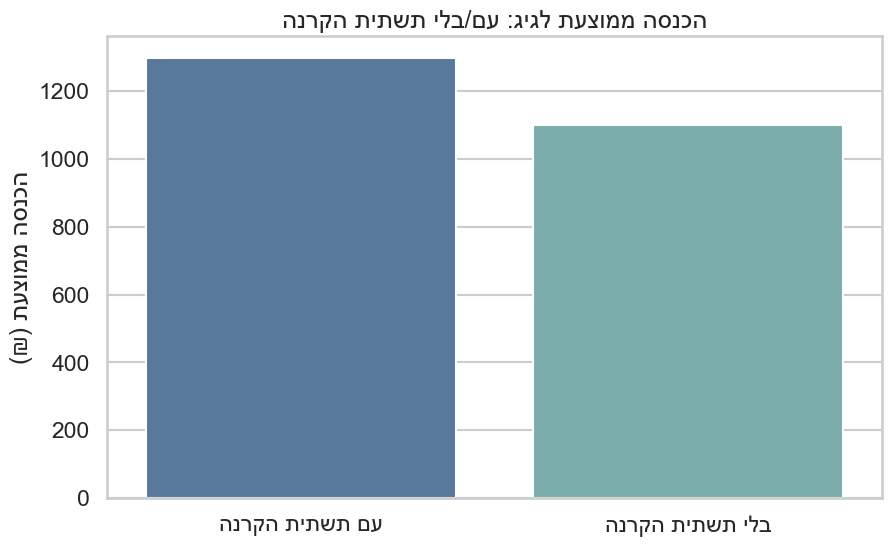

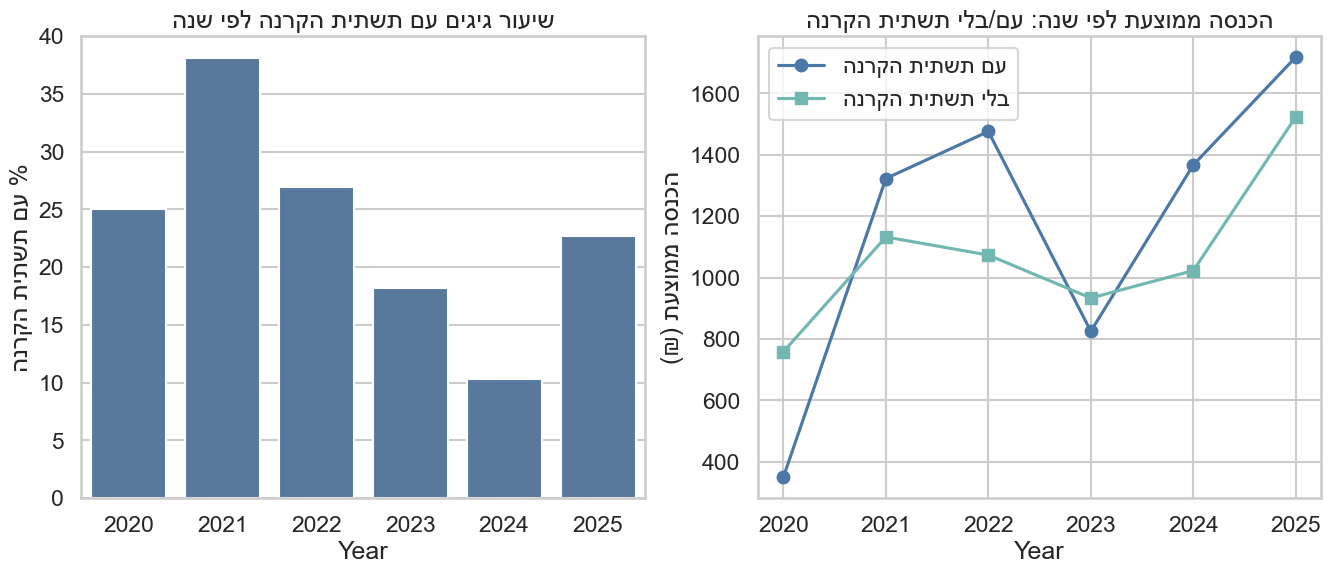

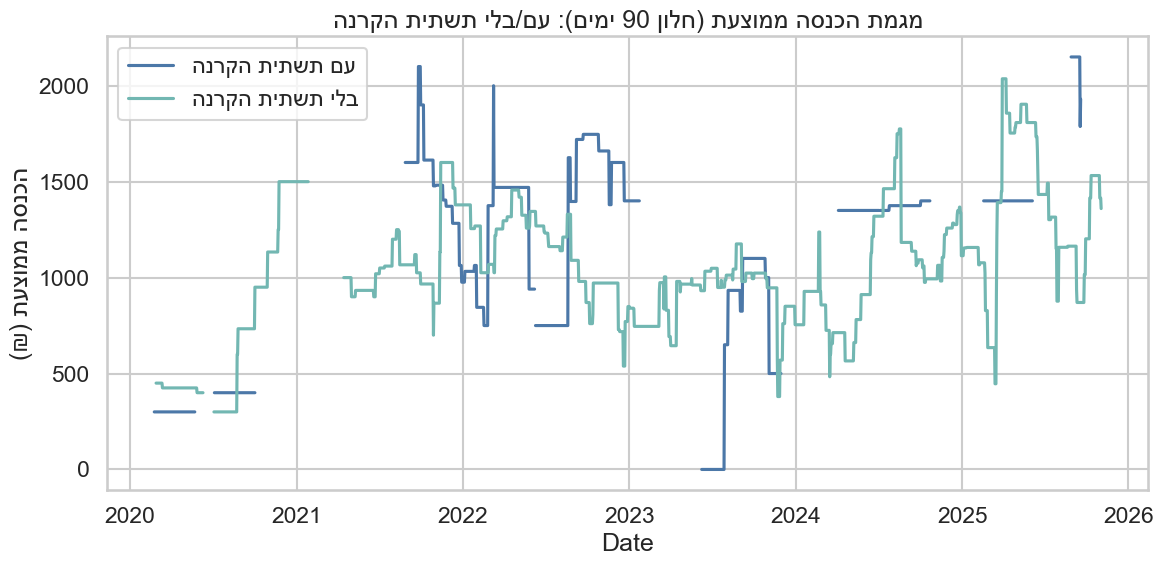

/var/folders/tr/_8q7bfh92lqdqnhl95px0cvm0000gp/T/ipykernel_33131/4110555960.py:64: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



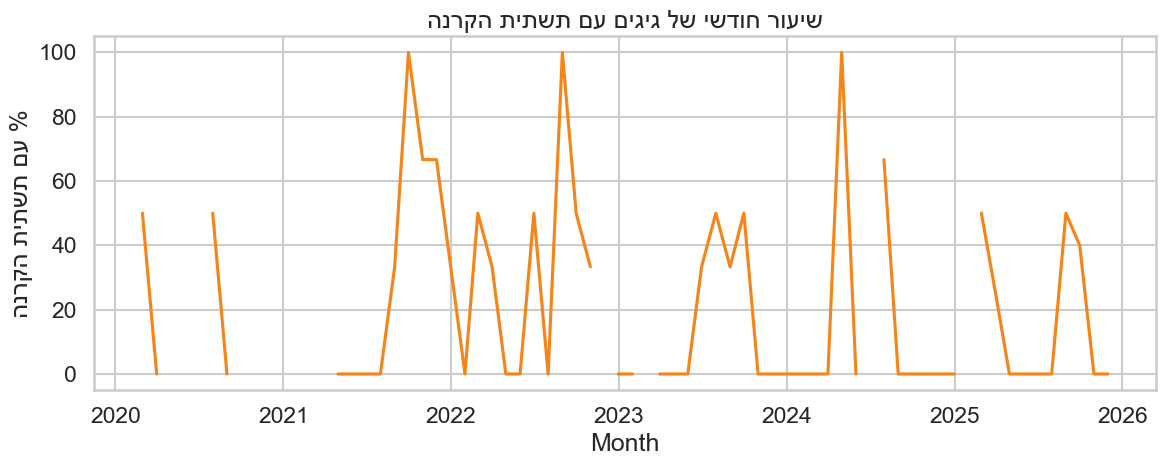

In [26]:
# Projection Infrastructure (תשתית הקרנה)
# Compare gigs where projection infra is required vs not

# Global comparison
proj_comp = df.groupby('projection_infra').agg(
    gigs=('income','count'),
    avg_income=('income','mean'),
    income=('income','sum')
)
proj_comp

plt.figure(figsize=(10,6))
sns.barplot(x=[he('עם תשתית הקרנה'), he('בלי תשתית הקרנה')],
            y=[proj_comp.loc[True,'avg_income'] if True in proj_comp.index else 0,
               proj_comp.loc[False,'avg_income'] if False in proj_comp.index else 0],
            palette=['#4C78A8','#72B7B2'])
plt.title(he('הכנסה ממוצעת לגיג: עם/בלי תשתית הקרנה'))
plt.ylabel(he('הכנסה ממוצעת (₪)'))
plt.show()

# Yearly share and avg income
yr_proj = df.groupby(['year','projection_infra']).agg(gigs=('income','count'), income=('income','sum'))
yr_proj['avg_income'] = yr_proj['income']/yr_proj['gigs']
yr_proj = yr_proj.reset_index()

# Share per year
share = yr_proj.pivot(index='year', columns='projection_infra', values='gigs').fillna(0)
share['pct_with_proj'] = 100* share.get(True, 0) / (share.sum(axis=1).replace(0, np.nan))

fig, ax = plt.subplots(1,2, figsize=(16,6))
sns.barplot(ax=ax[0], x=share.index, y=share['pct_with_proj'], color='#4C78A8')
ax[0].set_title(he('שיעור גיגים עם תשתית הקרנה לפי שנה'))
ax[0].set_xlabel('Year')
ax[0].set_ylabel(he('% עם תשתית הקרנה'))

# Avg income per year by flag
yr_avg = yr_proj.pivot(index='year', columns='projection_infra', values='avg_income')
ax[1].plot(yr_avg.index, yr_avg.get(True, pd.Series(index=yr_avg.index)), marker='o', color='#4C78A8', label=he('עם תשתית הקרנה'))
ax[1].plot(yr_avg.index, yr_avg.get(False, pd.Series(index=yr_avg.index)), marker='s', color='#72B7B2', label=he('בלי תשתית הקרנה'))
ax[1].set_title(he('הכנסה ממוצעת לפי שנה: עם/בלי תשתית הקרנה'))
ax[1].set_xlabel('Year')
ax[1].set_ylabel(he('הכנסה ממוצעת (₪)'))
ax[1].legend()
plt.show()

# Rolling trends (time-windowed comparison)
# Sort by date and create 90-day rolling averages per flag
sdf = df.sort_values('date').set_index('date')
roll_window = '90D'
roll_with = sdf[sdf['projection_infra']].resample('D').agg({'income':'mean'}).rolling(90, min_periods=1).mean()
roll_without = sdf[~sdf['projection_infra']].resample('D').agg({'income':'mean'}).rolling(90, min_periods=1).mean()

plt.figure(figsize=(12,6))
plt.plot(roll_with.index, roll_with['income'], label=he('עם תשתית הקרנה'), color='#4C78A8')
plt.plot(roll_without.index, roll_without['income'], label=he('בלי תשתית הקרנה'), color='#72B7B2')
plt.title(he('מגמת הכנסה ממוצעת (חלון 90 ימים): עם/בלי תשתית הקרנה'))
plt.xlabel('Date')
plt.ylabel(he('הכנסה ממוצעת (₪)'))
plt.legend()
plt.tight_layout()
plt.show()

# Rolling share of gigs with projection infra (by month)
monthly = df.set_index('date').resample('M').agg(gigs=('income','count'), with_proj=('projection_infra','sum'))
monthly['pct_with_proj'] = 100 * monthly['with_proj']/monthly['gigs'].replace(0, np.nan)
plt.figure(figsize=(12,5))
plt.plot(monthly.index, monthly['pct_with_proj'], color='#F58518')
plt.title(he('שיעור חודשי של גיגים עם תשתית הקרנה'))
plt.xlabel('Month')
plt.ylabel(he('% עם תשתית הקרנה'))
plt.tight_layout()
plt.show()


## Notes
- All income figures use formula: תשלום − 0.05×חשבונית (חשבונית missing → 0).
- Client normalization: all variants of מגוונים consolidated to 'מגוונים'.
- Band-like detection is heuristic via presence of 'מופע/להקה' tokens.
- The 3D yearly chart shows years (x), gig volume (y), and average income (z). A 2D dual-axis chart is provided alongside for readability.
